!pip install chess
!pip install tqdm

# !conda list

!conda env export --name dask-tutorial > grandmaster.yml

In [1]:
import numpy as np
import pandas as pd
import chess
import chess.pgn
from ChessFunctions import get_encoded_board, flatten_board
from tqdm import tqdm
import dask
from dask_ml.model_selection import train_test_split as d_train_test_split
from dask_ml.model_selection import GridSearchCV as d_GridSearchCV
import dask.dataframe as dd
import dask.array as da
from dask import delayed
import joblib

In [2]:
GAME_COUNT = 157

In [3]:
from dask.distributed import Client, progress
client = Client()
client

Client Scheduler: tcp://127.0.0.1:57356 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


In [4]:
f = open('lichess_elite_2020-06.pgn')

In [5]:
%%time 
my_list = []
Y_labels = []
for i in tqdm(range(GAME_COUNT)):
# while True:
    game = chess.pgn.read_game(f)
    if game is None:
        break  # end of file
    my_list.append(game)

100%|██████████| 157/157 [00:00<00:00, 406.36it/s]

CPU times: user 373 ms, sys: 16 ms, total: 389 ms
Wall time: 388 ms


In [6]:
def game_to_df(game):
    #if game.headers['Termination']=='Normal':
    board = game.board() 
    board_state = [flatten_board(board)]
    for move in game.mainline_moves():
        board.push(move)
        board_state = np.row_stack((board_state,flatten_board(board)))
    df = pd.DataFrame(board_state)
    df['gameid'] = game.headers["LichessURL"]
    df['result'] = np.where(game.headers["Result"]=='1-0',1,
                                np.where(game.headers["Result"]=='0-1',-1,0))
    df = df[10:]
    return df

In [7]:
%%time
allgame_df = []
for game in tqdm(my_list):
    df = delayed(game_to_df)(game)
    allgame_df.append(df)

100%|██████████| 157/157 [00:00<00:00, 33214.25it/s]

CPU times: user 4.94 ms, sys: 1 ms, total: 5.94 ms
Wall time: 5.63 ms


CPU times: user 20.1 ms, sys: 14.3 ms, total: 34.5 ms
Wall time: 999 ms


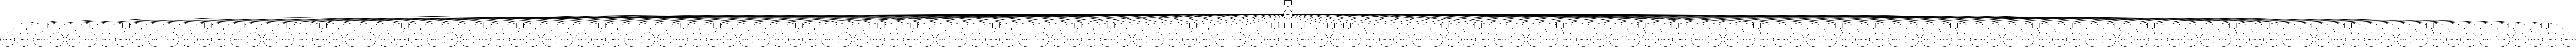

In [8]:
%%time
allgame_df_concat = delayed(pd.concat)(allgame_df)
allgame_df_concat.visualize()

In [9]:
ddf = dd.from_delayed(allgame_df)
#ddf = dd.from_pandas(allgame_df,npartitions=1000000)
ddf['features'] = ddf[0].apply(get_encoded_board,meta=('I'))
#ddf.compute()

def func(df):
    return df.features.apply(pd.Series, 1).stack().reset_index(level=1, drop=True)

feature_array = np.array(ddf.map_partitions(func).compute()).reshape(-1,770)

In [11]:
#features_array = np.array(list(ddf.features))
def get_array(df):
    print(df)
    return np.array(list(df.features))
feature_array = ddf.map_partitions(get_array).compute()
#feature_array.shape

     0 gameid  result  features
0  foo    foo       1         1
1  foo    foo       1         1


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 156 has 1 dimension(s)

In [30]:
x = ddf.compute().features.apply(lambda x: len(x))
x[x!=770]

Series([], Name: features, dtype: int64)

In [ ]:
X = feature_array
Y_labels = ddf.compute()['result']
print("X: " + str(X.shape))
print("Y: " + str(Y_labels.shape))

In [ ]:
%%time
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
X_train, X_test, y_train, y_test = d_train_test_split(
    X, Y_labels, train_size = 0.9
    ,random_state=1
)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
%%time
param_grid = {'hidden_layer_sizes':[(50,40,30)]
              ,'tol':[0.00001]
              ,'activation':['relu','logistic']
              ,'max_iter':[2000]
#               ,'learning_rate':['constant','invscaling','adaptive']
              ,'learning_rate_init':[0.0001]
#               ,'early_stopping':[False, True]
             }
mlp = MLPClassifier()
with joblib.parallel_backend('dask'):
    clf = GridSearchCV(mlp, param_grid, n_jobs=-1)
clf.fit(X_train, y_train)

In [ ]:
print(clf.score(X_test, y_test))
clf.best_estimator_

In [ ]:
# clf.predict(X_test)

In [ ]:
from joblib import dump, load
dump(clf, 'FinalModel.joblib')  

In [ ]:
clf = load('filename.joblib') 
clf.classes_

In [ ]:
import torch

In [ ]:
# class Feedforward(torch.nn.Module):
#         def __init__(self, input_size, hidden_size):
#             super(Feedforward, self).__init__()
#             self.input_size = input_size
#             self.hidden_size  = hidden_size
#             self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
#             self.relu = torch.nn.ReLU()
#             self.fc2 = torch.nn.Linear(self.hidden_size, 1)
#             self.sigmoid = torch.nn.Sigmoid()
#         def forward(self, x):
#             hidden = self.fc1(x)
#             relu = self.relu(hidden)
#             output = self.fc2(relu)
#             output = self.sigmoid(output)
#             return output

In [ ]:
# model = Feedforward(770, 100)
# criterion = torch.nn.BCELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [ ]:
# import tensorflow as tf
# X_test_tensor = tf.convert_to_tensor(X_test)

In [ ]:
# model.eval()
# y_pred = model(X_test)
# before_train = criterion(y_pred.squeeze(), y_test)
# print('Test loss before training' , before_train.item())
